In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 28 22:10:58 2019

@author: Donggeun Kwon (donggeun.kwon@gmail.com)

Cryptographic Algorithm Lab.
Graduate School of Information Security, Korea University
"""
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import keras.layers as layers

# when you use colab.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


In [0]:
# Hyper parameter
total_epochs = 200
batch_siz = 128
learning_rate = 0.001

# 추가적인 파라미터
len_seq = 30 # 며칠 이전 데이터부터 입력할지


In [3]:
# Load the dataset
stock = pd.read_csv('/content/gdrive/My Drive/Database/skhynix/SK-hynix_StockPrice.csv')
print(stock.head())

stock_data = np.array(stock.values[:-1, 1:].astype(np.float))
stock_data[np.isnan(stock_data)] = 0 # nan to zero

# Normalize
norm_stk = ((stock_data - np.min((stock_data.T), axis=1)) 
    / (np.max((stock_data.T), axis=1) - np.min((stock_data.T), axis=1) + 1e-7))

        년/월/일       종가       시가  ...  None  None  None
0  2000-01-04  25750.0  24700.0  ...   0.000000    -0.022519   0.000000
1  2000-01-05  23100.0  24150.0  ...   0.000000    -0.027284   0.000000
2  2000-01-06  21900.0  23500.0  ...   0.000000    -0.102999   0.000000
3  2000-01-07  21700.0  21200.0  ...   0.007915     0.037041   0.003369
4  2000-01-10  21500.0  22000.0  ...   0.007198     0.000000   0.045153

[5 rows x 13 columns]


In [0]:
# 학습 주기 
# 현재는 다음날 데이터만 예측하도록 학습 
x = np.array([norm_stk[i:i+len_seq] 
                for i in range(norm_stk.shape[0] - len_seq)]) # 학습 데이터
high = np.array([norm_stk[i + len_seq, 2] 
                for i in range(norm_stk.shape[0] - len_seq)]) # 고가 
low = np.array([norm_stk[i + len_seq, 3] 
                for i in range(norm_stk.shape[0] - len_seq)]) # 저가 

In [5]:
# 학습 데이터와 테스트 데이터 분류 
y = high
# y = low

rand_idx = np.arange(0, len(x))
# np.random.shuffle(rand_idx) # 시간과 무관하게 샘플링 
num_training_data = int(len(x) * 0.95) # 학습 데이터 중 95% 이용
print('Training data number is ' + str(num_training_data))

training_idx = rand_idx[:num_training_data]
test_idx = rand_idx[num_training_data:]
x_train = x[training_idx]
y_train = y[training_idx]
x_test = x[test_idx]
y_test = y[test_idx]

Training data number is 4467


In [6]:
# LSTM 간단한 모델 설계 
inp = layers.Input(shape = (len_seq, 12))
bat1 = layers.BatchNormalization()(inp)
rnn1 = layers.LSTM(60, return_sequences=False)(bat1)
bat2 = layers.BatchNormalization()(rnn1)
dnn1 = layers.Dense(20, activation='tanh')(bat2)
bat3 = layers.BatchNormalization()(dnn1)
out = layers.Dense(1, activation = 'sigmoid')(bat3)

rnn_model_high = keras.Model(inp, out)
rnn_model_high.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, 
                                                       decay=0.00001), 
                  loss = 'mean_squared_error')

rnn_model_high.summary(80)

Instructions for updating:
Colocations handled automatically by placer.
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                (None, 30, 12)                  0           
________________________________________________________________________________
batch_normalization_1 (BatchNormali (None, 30, 12)                  48          
________________________________________________________________________________
lstm_1 (LSTM)                       (None, 60)                      17520       
________________________________________________________________________________
batch_normalization_2 (BatchNormali (None, 60)                      240         
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      1220        
_____________________________________

In [7]:
rnn_model_high.fit(x = x_train, y = y_train,
              validation_data=[x_test, y_test],
              batch_size=batch_siz,
              epochs=total_epochs)

Instructions for updating:
Use tf.cast instead.
Train on 4467 samples, validate on 236 samples
Epoch 1/200
4467/4467 [==============================] - 4s 785us/step - loss: 0.0448 - val_loss: 0.0467
Epoch 2/200
4467/4467 [==============================] - 2s 406us/step - loss: 0.0187 - val_loss: 0.0479
Epoch 3/200
4467/4467 [==============================] - 2s 467us/step - loss: 0.0106 - val_loss: 0.0481
Epoch 4/200
4467/4467 [==============================] - 2s 467us/step - loss: 0.0067 - val_loss: 0.0303
Epoch 5/200
4467/4467 [==============================] - 2s 465us/step - loss: 0.0065 - val_loss: 0.0425
Epoch 6/200
4467/4467 [==============================] - 2s 464us/step - loss: 0.0038 - val_loss: 0.0301
Epoch 7/200
4467/4467 [==============================] - 2s 457us/step - loss: 0.0031 - val_loss: 0.0482
Epoch 8/200
4467/4467 [==============================] - 2s 458us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 9/200
4467/4467 [==============================] - 2s 455us

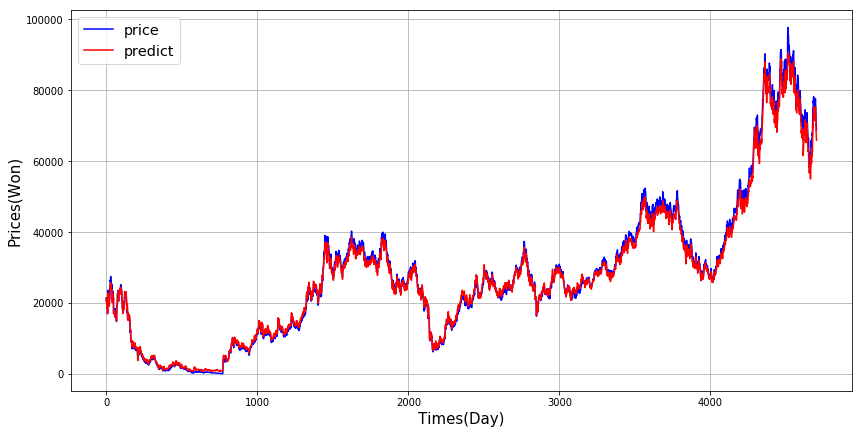

In [16]:
# 예측 원본 값으로 복원
y_pred = rnn_model_high.predict(x)
high_predict = ((y_pred * (np.max((stock_data.T)[2]) - np.min((stock_data.T)[2]) + 1e-7)) 
          + np.min((stock_data.T)[2]))
high_price = np.array([stock_data[i + len_seq, 2] for i in range(stock_data.shape[0] - len_seq)]) 

# 예측 그래프 시각화 
plt.figure(figsize=(14, 7))
plt.plot(high_price, color = 'blue', label='price')
plt.plot(high_predict, color = 'red', label='predict')
plt.xlabel('Times(Day)', size=15)
plt.ylabel('Prices(Won)', size=15)
plt.legend(loc='upper left', fontsize = 'x-large')
plt.grid(True)
plt.show()

In [0]:
# 학습 데이터와 테스트 데이터 분류 
# y = high
y = low

# high와 동일한 데이터 사용 
training_idx = rand_idx[:num_training_data]
test_idx = rand_idx[num_training_data:]
x_train = x[training_idx]
y_train = y[training_idx]
x_test = x[test_idx]
y_test = y[test_idx]

In [10]:
# LSTM 간단한 모델 설계 
inp_ = layers.Input(shape = (len_seq, 12))
bat1_ = layers.BatchNormalization()(inp_)
rnn1_ = layers.LSTM(60, return_sequences=False)(bat1_)
bat2_ = layers.BatchNormalization()(rnn1_)
dnn1_ = layers.Dense(20, activation='tanh')(bat2_)
bat3_ = layers.BatchNormalization()(dnn1_)
out_ = layers.Dense(1, activation = 'sigmoid')(bat3_)

rnn_model_low = keras.Model(inp_, out_)
rnn_model_low.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, 
                                                      decay=0.00001), 
                  loss = 'mean_squared_error')

rnn_model_low.fit(x = x_train, y = y_train,
              validation_data=[x_test, y_test],
              batch_size=batch_siz,
              epochs=total_epochs)

Train on 4467 samples, validate on 236 samples
Epoch 1/200
4467/4467 [==============================] - 3s 617us/step - loss: 0.0390 - val_loss: 0.0471
Epoch 2/200
4467/4467 [==============================] - 2s 379us/step - loss: 0.0167 - val_loss: 0.0473
Epoch 3/200
4467/4467 [==============================] - 2s 376us/step - loss: 0.0111 - val_loss: 0.0473
Epoch 4/200
4467/4467 [==============================] - 2s 373us/step - loss: 0.0068 - val_loss: 0.0461
Epoch 5/200
4467/4467 [==============================] - 2s 382us/step - loss: 0.0048 - val_loss: 0.0406
Epoch 6/200
4467/4467 [==============================] - 2s 378us/step - loss: 0.0033 - val_loss: 0.0350
Epoch 7/200
4467/4467 [==============================] - 2s 379us/step - loss: 0.0031 - val_loss: 0.0423
Epoch 8/200
4467/4467 [==============================] - 2s 378us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/200
4467/4467 [==============================] - 2s 377us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10

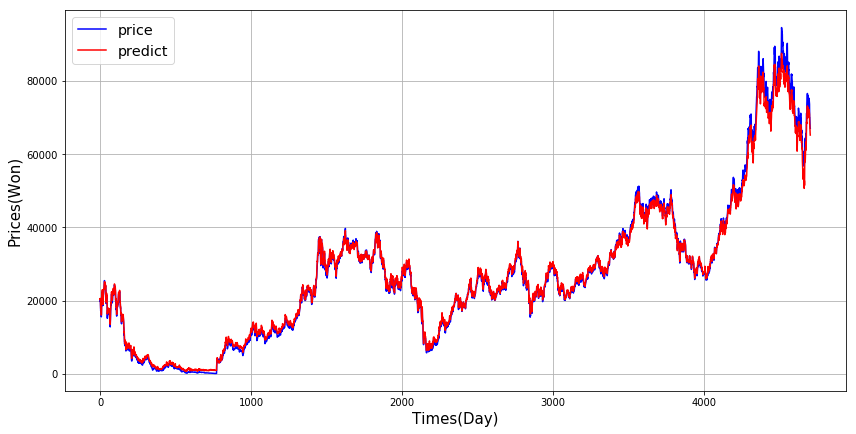

In [15]:
# 예측 원본 값으로 복원
y_pred = rnn_model_low.predict(x)
low_predict = ((y_pred * (np.max((stock_data.T)[3]) - np.min((stock_data.T)[3]) + 1e-7)) 
          + np.min((stock_data.T)[3]))
low_price = np.array([stock_data[i + len_seq, 3] for i in range(stock_data.shape[0] - len_seq)]) 

# 예측 그래프 시각화 
plt.figure(figsize=(14, 7))
plt.plot(low_price, color = 'blue', label='price')
plt.plot(low_predict, color = 'red', label='predict')
plt.xlabel('Times(Day)', size=15)
plt.ylabel('Prices(Won)', size=15)
plt.legend(loc='upper left', fontsize = 'x-large')
plt.grid(True)
plt.show()

In [0]:
import scipy
import scipy.io
from datetime import datetime
now = datetime.now()
scipy.io.savemat(now.strftime('%Y%m%d-%H%M%S') + '_prediction.mat', 
                 {'high_pred': high_predict,
                  'high_pric': high_price,
                  'low_pred' : low_predict,
                  'low_pric' : low_price})

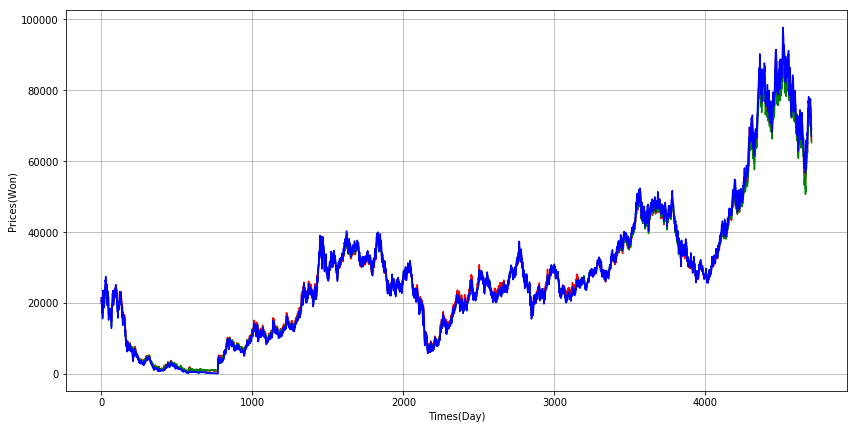

In [14]:
# 예측 그래프 시각화 
plt.figure(figsize=(14, 7))
plt.plot(high_predict, color = 'red')
plt.plot(low_predict, color = 'green')
plt.plot(low_price, color = 'blue')
plt.plot(high_price, color = 'blue')
plt.xlabel('Times(Day)', size=10)
plt.ylabel('Prices(Won)', size=10)
plt.grid(True)
plt.show()